In [1]:
import cv2
import torch
import torchvision
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from monai.transforms import (
    apply_transform,
    Randomizable,
    Compose,
    OneOf,
    EnsureChannelFirstDict,
    LoadImageDict,
    SpacingDict,
    OrientationDict,
    DivisiblePadDict,
    CropForegroundDict,
    ResizeDict,
    RandZoomDict,
    ZoomDict,
    RandRotateDict,
    HistogramNormalizeDict,
    ScaleIntensityDict,
    ScaleIntensityRangeDict,
    ToTensorDict,
    Transform
)

In [2]:
import os
import glob
from tqdm.auto import tqdm

In [3]:
def glob_files(folders: str = None, extension: str = "*.nii.gz"):
    assert folders is not None
    paths = [
        glob.glob(os.path.join(folder, extension), recursive=True)
        for folder in folders
    ]
    files = sorted([item for sublist in paths for item in sublist])
    print(len(files))
    print(files[:1])
    return files

In [4]:
ct_folders = [
    "/home/quantm/data/ChestXRLungSegmentation/NSCLC/processed/train/images",
]
ct_images = glob_files(
    ct_folders, 
    extension="*.nii.gz"
)

402
['/home/quantm/data/ChestXRLungSegmentation/NSCLC/processed/train/images/LUNG1-001_0000.nii.gz']


In [5]:
from util.camera import make_cameras_dea

In [6]:
# Run forward pass
device = torch.device('cuda:0')
B = 1

fov=12.0
znear=7
zfar=9

In [7]:
def correct_window(
    T_old, 
    a_min=-1024, 
    a_max=3071, 
    b_min=-1024, #-100, #-512, 
    b_max=3071, #+900, #3071, #1536, #2560, 
    factor=1.0    
):
    # Calculate the range for the old and new scales
    range_old = a_max - a_min
    range_new = b_max - b_min

    # Reverse the incorrect scaling
    T_raw = (T_old * range_old) + a_min

    # Apply the correct scaling
    T_new = (T_raw - b_min) / range_new 
    return T_new.clamp(0, 1)


In [8]:
# Define the transformation pipeline for "image2d"
val_transforms = Compose(
    [
        LoadImageDict(keys=["image3d"]),
        EnsureChannelFirstDict(keys=["image3d"],),
        SpacingDict(
            keys=["image3d"],
            pixdim=(1.0, 1.0, 1.0),
            mode=["bilinear"],
            align_corners=True,
        ),
        OrientationDict(keys=("image3d"), axcodes="ASL"),
        ScaleIntensityRangeDict(
            keys=["image3d"],
            clip=True,
            a_min=-1024,
            a_max=+3071,
            b_min=0.0,
            b_max=1.0,
        ),
        ScaleIntensityRangeDict(
            keys=["image3d"],
            clip=True,
            a_min=-1024,
            a_max=+3071,
            b_min=-1024,
            b_max=+3071,
        ),
        # CropForegroundDict(
        #     keys=["image3d"],
        #     source_key="image3d",
        #     select_fn=(lambda x: x > 0),
        #     margin=0,
        # ),
        # ZoomDict(keys=["image3d"], zoom=0.95, padding_mode="constant", mode=["area"]),
        ResizeDict(
            keys=["image3d"],
            spatial_size=256,
            size_mode="longest",
            mode=["trilinear"],
            align_corners=True,
        ),
        DivisiblePadDict(
            keys=["image3d"],
            k=256,
            mode="constant",
            constant_values=0,
        ),
        ToTensorDict(keys=["image3d"],),
    ]
)

In [10]:
i = 22 #11
data = {}
data["image3d"] = ct_images[i]
image3d = val_transforms(data)

image3d = image3d["image3d"].to(device)
image3d = image3d.unsqueeze(0)
print(image3d.shape)
image3d = correct_window(image3d)

#
print(image3d.max(), image3d.min())


torch.Size([1, 1, 256, 256, 256])
metatensor(1.0000, device='cuda:0') metatensor(0., device='cuda:0')


In [11]:

# from dvr.renderer import ScreenCentricXRayVolumeRenderer
# fwd_renderer = ScreenCentricXRayVolumeRenderer(
#     image_width=256,
#     image_height=256,
#     n_pts_per_ray=800,
#     min_depth=znear,
#     max_depth=zfar,
#     ndc_extent=1.0,
# )

# data = {}
# data["image3d"] = ct_images[i]
# image3d = val_transforms(data)

# image3d = image3d["image3d"].to(device)
# image3d = image3d.unsqueeze(0)
# image3d = transform_hu_to_density(image3d)
# # image3d = correct_window(image3d)

# output = fwd_renderer.forward(
#     image3d=image3d, 
#     cameras=view_hidden, 
# ).clamp_(0, 1).squeeze().detach().cpu()
# output = (255*output).astype(torch.uint8).unsqueeze(0) #.transpose(-1, -2)

# torchvision.io.write_png(output, f"ScreenCentricXRayHiddenImage.png")
# Image(filename="ScreenCentricXRayHiddenImage.png")

One or more elements of rays_densities are outside of validrange (0.0, 1.0)


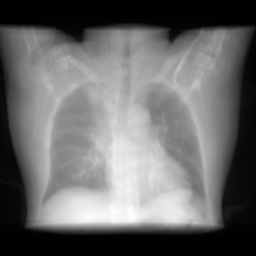

In [12]:
from dvr.renderer import ObjectCentricXRayVolumeRenderer
fwd_renderer = ObjectCentricXRayVolumeRenderer(
    image_width=256,
    image_height=256,
    n_pts_per_ray=800,
    min_depth=znear,
    max_depth=zfar,
    ndc_extent=1.0,
)

data = {}
data["image3d"] = ct_images[i]
image3d = val_transforms(data)

image3d = image3d["image3d"].to(device)
image3d = image3d.unsqueeze(0)
# image3d = transform_hu_to_density(image3d)
image3d = correct_window(image3d)

dist_hidden = 8 * torch.ones(B, device=device)
elev_hidden = torch.zeros(B, device=device)
azim_hidden = torch.zeros(B, device=device)
view_hidden = make_cameras_dea(
    dist_hidden, 
    elev_hidden, 
    azim_hidden, 
    fov=fov, 
    znear=znear, 
    zfar=zfar,
).to(device)



output = fwd_renderer.forward(
    image3d=image3d, 
    cameras=view_hidden, 
).clamp_(0, 1).squeeze().detach().cpu()
output = (255*output).astype(torch.uint8).unsqueeze(0) 

torchvision.io.write_png(output, f"ObjectCentricXRayHiddenImage.png")
Image(filename="ObjectCentricXRayHiddenImage.png")

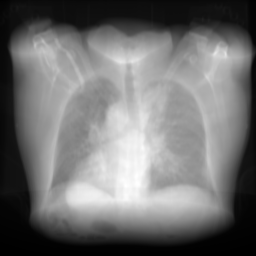

In [18]:
from dvr.renderer import ObjectCentricXRayVolumeRenderer
fwd_renderer = ObjectCentricXRayVolumeRenderer(
    image_width=256,
    image_height=256,
    n_pts_per_ray=800,
    min_depth=znear,
    max_depth=zfar,
    ndc_extent=1.0,
)

data = {}
data["image3d"] = ct_images[i]
image3d = val_transforms(data)

image3d = image3d["image3d"].to(device)
image3d = image3d.unsqueeze(0)
# image3d = transform_hu_to_density(image3d)
image3d = correct_window(image3d)

dist_lateral = 8 * torch.ones(B, device=device)
elev_lateral = torch.ones(B, device=device) * -20
azim_lateral = torch.ones(B, device=device) * 180
view_lateral = make_cameras_dea(
    dist_lateral, 
    elev_lateral, 
    azim_lateral, 
    fov=fov, 
    znear=znear, 
    zfar=zfar,
).to(device)


output = fwd_renderer.forward(
    image3d=image3d, 
    cameras=view_lateral, 
).clamp_(0, 1).squeeze().detach().cpu()
output = (255*output).astype(torch.uint8).unsqueeze(0) 

torchvision.io.write_png(output, f"ObjectCentricXRaySideImage.png")
Image(filename="ObjectCentricXRaySideImage.png")